In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import joblib
import torch

from sklearn.metrics import classification_report , confusion_matrix , accuracy_score , auc
from sklearn.model_selection import train_test_split
import cv2
#from google.colab.patches import cv2_imshow
from PIL import Image 
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Input, Dense,Conv2D , MaxPooling2D, Flatten,BatchNormalization,Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_hub as hub 
!pip install scikit-learn
from sklearn.metrics import balanced_accuracy_score
from tensorflow.keras.optimizers import Adam



In [2]:
x = joblib.load("/kaggle/input/preprocessing-done/x_data.joblib")
y = joblib.load("/kaggle/input/preprocessing-done/y_data.joblib")
img_ids = joblib.load("/kaggle/input/preprocessing-done/img_ids.joblib")
print(x.shape)
print(y.shape)

(10763, 256, 256, 3)
(10763,)


In [3]:
x1=x[:7500]
y1=y[:7500]
img_ids1=img_ids[:7500]
x_train, x_test, y_train, y_test, img_ids_train, img_ids_test = train_test_split(x1, y1, img_ids1, test_size=0.15, shuffle=True, random_state=42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(6375, 256, 256, 3)
(1125, 256, 256, 3)
(6375,)
(1125,)


In [4]:
import tensorflow as tf
import tensorflow_hub as hub

seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)


# Load the pre-trained ResNet-v2 model from TensorFlow Hub
base_model = tf.keras.Sequential([
    hub.KerasLayer("https://www.kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/50-classification/versions/2",
                   trainable=True, arguments=dict(batch_norm_momentum=0.997))
])

# Build the model with a specific input shape
base_model.build([None, 256, 256, 3])  # Batch input shape.

# Omit the last layer from the base_model
base_model = tf.keras.Model(inputs=base_model.input, outputs=base_model.layers[-1].output)

# Optionally, make some layers trainable
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Define your custom top layers for classification
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dropout(0.05),  # Dropout layer for regularization
    tf.keras.layers.Dense(6, activation='softmax')  # Output layer with 6 units and softmax activation
])

# Compile the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']  # Add Balanced Accuracy as a metric
)

# Convert labels to one-hot encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=6)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=6)

# Manually calculate class weights based on class distribution
num_classes = 6
class_weights = {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1}  # Set epsilon value for class 5

# Set a small non-zero value for classes with no samples
epsilon = 1e-10
total_samples = len(y_train)

for c in range(num_classes):
    class_count = len(y_train[y_train == c])
    if class_count == 0:
        class_weights[c] = epsilon  
    else:
        class_weights[c] = total_samples / ((num_classes * class_count) + epsilon)

# Implement a learning rate schedule
def learning_rate_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.9

# Print class weights
print("Class Weights:", class_weights)

# Compile the model with manually calculated class weights and custom learning rate
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

# Augmenting training data
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=None  
)

datagen.fit(x_train)

# Fine-tune the model with dropout layers
history = model.fit(datagen.flow(x_train, y_train, batch_size=64), validation_data=(x_test, y_test),
                    steps_per_epoch=len(x_train) // 64, epochs=7, class_weight=class_weights,
                    callbacks=[tf.keras.callbacks.LearningRateScheduler(learning_rate_scheduler),
                               tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])


Class Weights: {0: 0.5254698318496495, 1: 1.0830784913353537, 2: 0.8123088685015187, 3: 0.9231103388357816, 4: 1.163745892661534, 5: 1e-10}
Epoch 1/7
99/99 [==============================] - 132s 895ms/step - loss: 1.5032 - accuracy: 0.4243 - val_loss: 2.1333 - val_accuracy: 0.4267 - lr: 1.0000e-04
Epoch 2/7
99/99 [==============================] - 89s 893ms/step - loss: 1.2311 - accuracy: 0.5490 - val_loss: 2.2852 - val_accuracy: 0.4400 - lr: 1.0000e-04
Epoch 3/7
99/99 [==============================] - 89s 898ms/step - loss: 1.1130 - accuracy: 0.6143 - val_loss: 1.8207 - val_accuracy: 0.5547 - lr: 1.0000e-04
Epoch 4/7
99/99 [==============================] - 90s 905ms/step - loss: 1.0351 - accuracy: 0.6500 - val_loss: 1.8694 - val_accuracy: 0.5307 - lr: 1.0000e-04
Epoch 5/7
99/99 [==============================] - 89s 896ms/step - loss: 0.9717 - accuracy: 0.6794 - val_loss: 1.8277 - val_accuracy: 0.5271 - lr: 1.0000e-04
Epoch 6/7
99/99 [==============================] - 90s 904ms/ste

In [5]:
# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Validation Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')


36/36 [==============================] - 2s 65ms/step - loss: 1.6808 - accuracy: 0.5804
Validation Loss: 1.6808, Accuracy: 0.5804


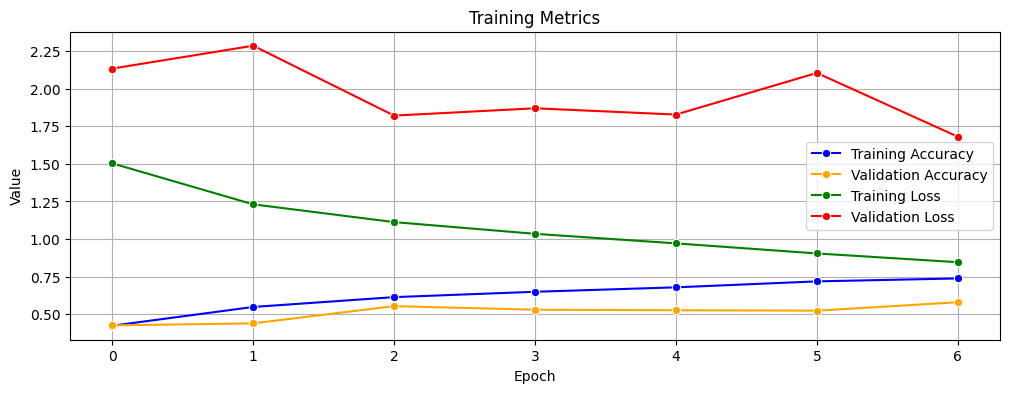

In [6]:
# Extract metrics from the training history
history_metrics = history.history

# Convert metrics to a DataFrame
metrics_df = pd.DataFrame(history_metrics)

# Plot the metrics using seaborn with different colors
plt.figure(figsize=(12, 4))
sns.lineplot(data=metrics_df['accuracy'], marker='o', label='Training Accuracy', color='blue')
sns.lineplot(data=metrics_df['val_accuracy'], marker='o', label='Validation Accuracy', color='orange')
sns.lineplot(data=metrics_df['loss'], marker='o', label='Training Loss', color='green')
sns.lineplot(data=metrics_df['val_loss'], marker='o', label='Validation Loss', color='red')
plt.title('Training Metrics')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
# Save the entire model to a HDF5 file
#model.save("/kaggle/working/resnet-v2-50.h5")

#from tensorflow.keras.models import save_model
#save_model(model, "/kaggle/working/resnet-v2-50.h5")

In [8]:
from tensorflow.keras.models import load_model
CNN_model = load_model('/kaggle/input/model12/CNN_model.h5')
VGG_model = load_model('/kaggle/input/model21/vgg_model.h5')

In [9]:
predictions1= CNN_model.predict(x_test)
predictions2= VGG_model.predict(x_test)
predictions3= model.predict(x_test)
#y_pred = np.argmax(predictions, axis=1)

36/36 [==============================] - 3s 62ms/step


In [10]:
weight1 = 0.1
weight2 = 0.3
weight3 = 0.6

# 根据权重对预测结果进行加权组合
ensemble_predictions = np.argmax(weight1 * predictions1 + weight2 * predictions2 + weight3 * predictions3, axis=1)

In [11]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, ensemble_predictions)
accuracy

0.6017777777777777

In [12]:
from collections import Counter
from sklearn.metrics import accuracy_score
def find_majority_label(image_ids, labels):
    id_label_map = {}  # 创建一个空的字典来存储image_id和对应的label

    # 遍历image_ids和labels列表
    for image_id, label in zip(image_ids, labels):
        if image_id in id_label_map:
            id_label_map[image_id].append(label)
        else:
            id_label_map[image_id] = [label]

    majority_labels = {}  # 创建一个空的字典来存储每个唯一image_id的多数投票label

    # 对字典中的每个唯一image_id的label列表进行多数投票
    for image_id, label_list in id_label_map.items():
        label_counts = Counter(label_list)
        majority_label = label_counts.most_common(1)[0][0]
        majority_labels[image_id] = majority_label

    return majority_labels

In [13]:
y_votingpred=find_majority_label(img_ids_test, ensemble_predictions)
# 对图像 ID 进行去重
unique_img_ids = np.unique(img_ids_test)

# 根据去重后的图像 ID，获取对应的真实标签和预测标签
y_test_matched = []
y_test_matched = np.array([y_test[np.where(img_ids_test == img_id)[0][0]] for img_id in unique_img_ids])
y_votingpred_matched = np.array([y_votingpred[img_id] for img_id in unique_img_ids])

# 计算准确度
accuracy = accuracy_score(y_test_matched, y_votingpred_matched)
accuracy

0.6005154639175257

In [14]:
from sklearn.metrics import balanced_accuracy_score

# 计算平衡准确率
balanced_acc = balanced_accuracy_score(y_test_matched, y_votingpred_matched)

print("balanced_acc:", balanced_acc)

balanced_acc: 0.6513949500965582


# 单独的resnet

In [15]:
'''from collections import Counter
from sklearn.metrics import accuracy_score
def find_majority_label(image_ids, labels):
    id_label_map = {}  # 创建一个空的字典来存储image_id和对应的label

    # 遍历image_ids和labels列表
    for image_id, label in zip(image_ids, labels):
        if image_id in id_label_map:
            id_label_map[image_id].append(label)
        else:
            id_label_map[image_id] = [label]

    majority_labels = {}  # 创建一个空的字典来存储每个唯一image_id的多数投票label

    # 对字典中的每个唯一image_id的label列表进行多数投票
    for image_id, label_list in id_label_map.items():
        label_counts = Counter(label_list)
        majority_label = label_counts.most_common(1)[0][0]
        majority_labels[image_id] = majority_label

    return majority_labels

y_votingpred=find_majority_label(img_ids_test, y_pred)
# 对图像 ID 进行去重
unique_img_ids = np.unique(img_ids_test)

# 根据去重后的图像 ID，获取对应的真实标签和预测标签
y_test_matched = []
y_test_matched = np.array([y_test[np.where(img_ids_test == img_id)[0][0]] for img_id in unique_img_ids])
y_votingpred_matched = np.array([y_votingpred[img_id] for img_id in unique_img_ids])

# 计算准确度
accuracy = accuracy_score(y_test_matched, y_votingpred_matched)
accuracy
0.6237113402061856'''

'from collections import Counter\nfrom sklearn.metrics import accuracy_score\ndef find_majority_label(image_ids, labels):\n    id_label_map = {}  # 创建一个空的字典来存储image_id和对应的label\n\n    # 遍历image_ids和labels列表\n    for image_id, label in zip(image_ids, labels):\n        if image_id in id_label_map:\n            id_label_map[image_id].append(label)\n        else:\n            id_label_map[image_id] = [label]\n\n    majority_labels = {}  # 创建一个空的字典来存储每个唯一image_id的多数投票label\n\n    # 对字典中的每个唯一image_id的label列表进行多数投票\n    for image_id, label_list in id_label_map.items():\n        label_counts = Counter(label_list)\n        majority_label = label_counts.most_common(1)[0][0]\n        majority_labels[image_id] = majority_label\n\n    return majority_labels\n\ny_votingpred=find_majority_label(img_ids_test, y_pred)\n# 对图像 ID 进行去重\nunique_img_ids = np.unique(img_ids_test)\n\n# 根据去重后的图像 ID，获取对应的真实标签和预测标签\ny_test_matched = []\ny_test_matched = np.array([y_test[np.where(img_ids_test == img_id)[0][0]] fo

In [16]:
'''from sklearn.metrics import balanced_accuracy_score

# 计算平衡准确率
balanced_acc = balanced_accuracy_score(y_test_matched, y_votingpred_matched)

print("balanced_acc:", balanced_acc)
balanced_acc: 0.62202165791326
'''

'from sklearn.metrics import balanced_accuracy_score\n\n# 计算平衡准确率\nbalanced_acc = balanced_accuracy_score(y_test_matched, y_votingpred_matched)\n\nprint("balanced_acc:", balanced_acc)\nbalanced_acc: 0.62202165791326\n'